In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [2]:
files = glob.glob('../../../IRL22SU/FeT_2271/*.txt')
files

#here is where the output will go 
path2 = '../../../IRL22SU/FeT_WC_2271.csv'
files

['../../../IRL22SU/FeT_2271\\227101_Absorbance__0__153.txt',
 '../../../IRL22SU/FeT_2271\\227101_Absorbance__1__154.txt',
 '../../../IRL22SU/FeT_2271\\227101_Absorbance__2__155.txt',
 '../../../IRL22SU/FeT_2271\\227101_Absorbance__3__156.txt',
 '../../../IRL22SU/FeT_2271\\227101_Absorbance__4__157.txt',
 '../../../IRL22SU/FeT_2271\\227101_Absorbance__5__158.txt',
 '../../../IRL22SU/FeT_2271\\227102_Absorbance__0__159.txt',
 '../../../IRL22SU/FeT_2271\\227102_Absorbance__1__160.txt',
 '../../../IRL22SU/FeT_2271\\227102_Absorbance__2__161.txt',
 '../../../IRL22SU/FeT_2271\\227103_Absorbance__0__162.txt',
 '../../../IRL22SU/FeT_2271\\227103_Absorbance__1__163.txt',
 '../../../IRL22SU/FeT_2271\\227103_Absorbance__2__164.txt',
 '../../../IRL22SU/FeT_2271\\227104_Absorbance__0__165.txt',
 '../../../IRL22SU/FeT_2271\\227104_Absorbance__0__168.txt',
 '../../../IRL22SU/FeT_2271\\227104_Absorbance__1__166.txt',
 '../../../IRL22SU/FeT_2271\\227104_Absorbance__1__169.txt',
 '../../../IRL22SU/FeT_2

In [3]:
def GET_DATA(name):
    df = pd.read_csv(name, skiprows=15, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']
    #df['wl'] = df['wl']
    #bcorr = df[(df['wl']>=700) & (df['wl']<=701)]['abs'].mean() # a float corection with just 700 nm 
    bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float corection with 700 to 750 nm 
    df['abs'] = df['abs'] - bcorr
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [4]:
frames = []
for f in files:
    df = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df['wl'] = df.index
df

,227101_Absorbance__0__153.txt,227101_Absorbance__1__154.txt,227101_Absorbance__2__155.txt,227101_Absorbance__3__156.txt,227101_Absorbance__4__157.txt,227101_Absorbance__5__158.txt,227102_Absorbance__0__159.txt,227102_Absorbance__1__160.txt,227102_Absorbance__2__161.txt,227103_Absorbance__0__162.txt,...,227104_Absorbance__1__169.txt,227104_Absorbance__2__167.txt,227104_Absorbance__2__170.txt,227105_Absorbance__0__171.txt,227105_Absorbance__1__172.txt,227105_Absorbance__2__173.txt,227106_Absorbance__0__174.txt,227106_Absorbance__1__175.txt,227106_Absorbance__2__176.txt,wl
wl,,,,,,,,,,,,,,,,,,,,,
189,-203331.928366,-2.925827e+06,-1.668488e+06,234934.130173,21420.136628,111874.771917,-650537.801837,-65692.936558,-810249.342322,-658778.412064,...,844189.155372,6823.448551,-2.088166e+06,-229153.573850,-3815.236519,-1.033858e+06,-831201.966512,-3502.748803,-376752.809862,189
190,-199178.993782,-2.866890e+06,-1.634900e+06,230197.926213,21055.984312,109679.094286,-637443.965359,-64368.942385,-793940.510036,-645514.618375,...,827251.020816,6722.861873,-2.046140e+06,-224504.491756,-3690.807267,-1.013047e+06,-814459.822504,-3432.466087,-369158.782926,190
191,-195082.977153,-2.808749e+06,-1.601766e+06,225525.806235,20695.846202,107512.320324,-624527.015744,-63062.857853,-777852.001642,-632430.062933,...,810540.984156,6623.137421,-2.004681e+06,-219918.711481,-3568.702685,-9.925173e+05,-797944.012628,-3363.129835,-361667.491751,191
192,-191043.485858,-2.751400e+06,-1.569083e+06,220917.333741,20339.701158,105374.258629,-611785.750061,-61774.561008,-761982.318780,-619523.526443,...,794057.499113,6524.272711,-1.963785e+06,-215395.799159,-3448.902586,-9.722666e+05,-781652.996586,-3294.733631,-354278.236679,192
193,-187060.127277,-2.694837e+06,-1.536847e+06,216372.072231,19987.528038,103264.717798,-599218.965385,-60503.929894,-746329.963090,-606793.789608,...,777799.019408,6426.265257,-1.923450e+06,-210935.320923,-3331.386780,-9.522932e+05,-765585.234081,-3227.271060,-346990.318050,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,-25.073342,-3.980093e+00,-1.831825e+02,-6.050129,-43.148151,-35.379864,237.433560,12.529912,11.387469,61.641367,...,7.943607,-0.021180,-3.129656e-02,118.708548,176.924714,1.175659e+02,49.067785,-0.001541,-61.645601,876
877,-26.506085,-4.224401e+00,-1.937387e+02,-6.413666,-45.618299,-37.409041,251.248871,13.246283,12.060358,65.182161,...,8.417685,-0.021381,-3.169954e-02,125.616204,187.242714,1.244301e+02,51.891401,-0.001541,-65.186395,877
878,-27.992375,-4.478445e+00,-2.046929e+02,-6.791446,-48.180936,-39.514365,265.589903,13.989428,12.759208,68.856008,...,8.910190,-0.021583,-3.210253e-02,132.786720,197.954193,1.315563e+02,54.821298,-0.001541,-68.860242,878


In [5]:
#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH
#this filters eveything by all that have the work 'Absorbance' with anything after it 
#and turns it into a new object 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
#edit here to make the names a 6 diget number code 
names = d.columns.str.rsplit('_', n=7).str[0]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = d.groupby(names, axis=1).mean()
df['wl'] = df.index
df

,227101,227102,227103,227104,227105,227106,wl
wl,,,,,,,
189,-738236.339078,-508826.693573,-351104.052939,-743444.775422,-422275.765734,-403819.175059,189
190,-723339.324796,-498584.472593,-344035.241532,-728436.800955,-413747.537949,-395683.690505,190
191,-708644.070492,-488480.625080,-337061.949505,-713632.168255,-405334.908448,-387658.211405,191
192,-694149.200592,-478514.209950,-330183.527101,-699029.490426,-397037.088453,-379741.988965,192
193,-679853.339521,-468684.286123,-323399.324560,-684627.380573,-388853.289184,-371934.274397,193
...,...,...,...,...,...,...,...
876,-49.469009,87.116980,33.853707,71.888816,137.733066,-4.193119,876
877,-52.318369,92.185170,35.806141,76.087600,145.763009,-4.432178,877
878,-55.275081,97.446179,37.832224,80.446712,154.099081,-4.680162,878


Text(0.5, 1.0, 'BC_ABS_BLU22_2226_GB')

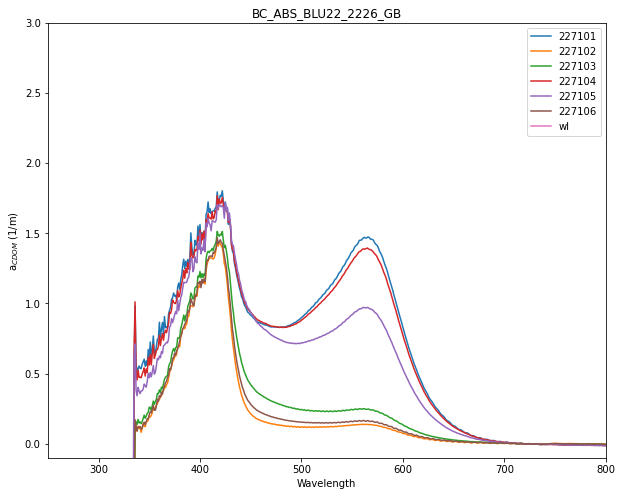

In [6]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-.1,3)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("BC_ABS_BLU22_2226_GB")


In [7]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    
    abs_562 = df[(df['wl']==562)][col].mean()
    
    ydata = df[(df['wl']>=450) & (df['wl']<=700)][col]
    xdata = df[(df['wl']>=450) & (df['wl']<=700)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    inter = scipy.integrate.simps(ydata, x=xdata, even='avg')
    
    dict = {'sample':[columnName],
        'abs_562':[abs_562], 
        'intagration':[inter],}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')
ss_outs.to_csv(path2)

ss_outs

,abs_562,intagration
sample,,
227101,1.471183,184.735696
227102,0.137980,21.594556
227103,0.250092,41.645943
227104,1.386817,177.619783
227105,0.970367,135.434126
227106,0.164521,27.035782


EXPERIMENTAL